# Feature Tutorial

Besides datatracks, another aspect of chromatin/genome/structural biology which is routinely needed to be investigated are features. This can be in an extremely broad sense but to a first approximation a genome feature is just a named region of the genome which doesn't change. This is distinct from datatracks which define some function over genomic regions (see the Datatrack tutorial). 

Ofcourse, we could just encode features as numpy arrays on some chromosome:

In [1]:
import numpy as np
myregion = np.array([10,20])
mychrom = '4'

myfeature = (mychrom, myregion)
print(myfeature)

('4', array([10, 20]))


However, this isn't the most flexible and when we scale to large numbers of features it may not even be so descriptive or useful. Firstly, we often need a way to link features together. For example:
- A given gene may be associated with a given promoter. 
- A topologically associated domain (TAD) may contain multiple promoters within it

Secondly, features may have condition-specific attributes which we might want to assign to them (while still having access to the same condition-independent feature). For example:

- A promoter might have active marks in naive mESCs but bivalent marks in primed mESCs
- A TAD may be within the A compartment in naive mESCs but move to the B compartment in primed mESCs

Finally, we may want to keep track of datatracks within specific classes of features. For example:

- We may want to know average rates of DNA methylation at active vs. bivalent promoters in naive mESCs

In order to do all of these things, we'll make use of the Datatrack classes and the Feature classes. A bit of work will be needed to create our feature classes but once done it will provide some flexible analysis tools.

## Modules

In [3]:
from GenTools import Feature as F
from GenTools import Datatrack as Dt
from GenTools.utils import dtrack_utils as dtu

import pandas as pd
import numpy as np

## The Feature Class
The main class which i'll use to encode general features is the Feature class. At it's base, all a feature needs is a chromosome, some regions and a unique ID which allows us to keep track of that feature:

In [4]:
myfeat1 = F.Feature('UID1', '1', np.array([[10,20]]).astype('int32'))

print("This is a feature of with ID:\t{}\nand with regions:\t{}\nonchromosome:\t{}".format(myfeat1.id, 
                                                                                         myfeat1.attrs['regions'],
                                                                                         myfeat1.attrs['chromosome']
                                                                                        ))

This is a feature of with ID:	UID1
and with regions:	[[10 20]]
onchromosome:	1


### Feature Attributes
One optional input when we construct our feature is attrs (attributes). Essentially this is extra info beyond the feature ID and the feature type which we might want to associate with the feature. Let's add a 'chromosome' attribute to our feature myfeat1:

In [5]:
myfeat1.attrs['type'] = 'gene'

print(myfeat1.attrs)

{'regions': array([[10, 20]], dtype=int32), 'chromosome': '1', 'type': 'gene'}


Feature attributes can really be anything:

In [6]:
myfeat1.attrs['splicing sites'] = np.array([[15,16],[18,19]]).astype('int32')
print(myfeat1.attrs)

{'regions': array([[10, 20]], dtype=int32), 'chromosome': '1', 'type': 'gene', 'splicing sites': array([[15, 16],
       [18, 19]], dtype=int32)}


### Feature Children
Features can also have children:

In [7]:
#Lets make a second feature of type 2
myfeat2 = F.Feature('UID2',
                    '1',
                    np.array([[11, 13]]).astype('int32')
                   )


#Now let's add it to our first feature as a child
myfeat1.add_child(myfeat2, #The child feature we want to add
                  'type2' #The type of child feature we're adding
                 )

The children of myfeat1 are stored in a dictionary in myfeat1.children. In particular, since we have specified our child type as 'type2', myfeat2 will appear in myfeat1.children['type2']:

In [8]:
print("Children of {}:".format(myfeat1.id))
print(myfeat1.children)

#We can also access the attributes of children
print("Attributes of {}".format(myfeat1.children['type2'][0].id))
print(myfeat1.children['type2'][0].attrs)

Children of UID1:
{'type2': [<GenTools.Feature.Feature object at 0x7fe3f5722190>]}
Attributes of UID2
{'regions': array([[11, 13]], dtype=int32), 'chromosome': '1'}


Note that at the moment there is nothing stopping the same feature from being added twice:

In [9]:
#Now let's add it to our first feature as a child
myfeat1.add_child(myfeat2, #The child feature we want to add
                  'type2' #The type of child feature we're adding
                 )

print(myfeat1.children)

{'type2': [<GenTools.Feature.Feature object at 0x7fe3f5722190>, <GenTools.Feature.Feature object at 0x7fe3f5722190>]}


However, since we have added the same feature (myfeat2) twice, note that the location of each item in the list myfeat1.children['type2'] is the same i.e. they're the same object. 

Let's see what happens if we add an attribute to our myfeat2:

In [10]:
print("Before editing the region the attributes of {} are:".format(myfeat2.id))
print(myfeat2.attrs)
print("\n")
print("###################################################")
#Changing the region of myfeat2 to be longer
myfeat2.attrs['regions'][0,1] = 17

print("After editing the region of the attributes of {}, accessing the attrs via {} we get:".format(myfeat2.id, myfeat2.id))
print(myfeat2.attrs)
print("\n")
print("###################################################")

print("After editing the region of the attributes of {}, accessing the attrs via {} we get:".format(myfeat2.id, myfeat1.id))
print("Child type2 number 0:")
print(myfeat1.children['type2'][0].attrs)
print("Child type2 number 1:")
print(myfeat1.children['type2'][1].attrs)

Before editing the region the attributes of UID2 are:
{'regions': array([[11, 13]], dtype=int32), 'chromosome': '1'}


###################################################
After editing the region of the attributes of UID2, accessing the attrs via UID2 we get:
{'regions': array([[11, 17]], dtype=int32), 'chromosome': '1'}


###################################################
After editing the region of the attributes of UID2, accessing the attrs via UID1 we get:
Child type2 number 0:
{'regions': array([[11, 17]], dtype=int32), 'chromosome': '1'}
Child type2 number 1:
{'regions': array([[11, 17]], dtype=int32), 'chromosome': '1'}


Because the two added children (both myfeat2) are actually the same object, when we edit that object, the same edits are applied to the children within myfeat1. 

Finally, the input 'type2' into the add_child method is not entirely necessary since it can be inferred from myfeat2:

In [11]:
myfeat1 = F.Feature('UID1', '1', np.array([[20,30]]).astype('int32'))
myfeat2 = F.Feature('UID2', '1', np.array([[15,25]]).astype('int32'))
myfeat1.add_child(myfeat2, 'type2')

print(myfeat1.children)

{'type2': [<GenTools.Feature.Feature object at 0x7fe3f5719550>]}


However, we may want to group children of the same type when we add children to our features. Therefore we can specify the child type:

In [12]:
myfeat1 = F.Feature('UID1', '1', np.array([[20,30]]).astype('int32'))
myfeat2 = F.Feature('UID2', '1', np.array([[15,25]]).astype('int32'), attrs = {'type': 'gene'})
myfeat3 = F.Feature('UID3', '1', np.array([[26,32]]).astype('int32'), attrs = {'type': 'gene'}) #Third feature of the same type as myfeat2 but with a different UID
myfeat1.add_child(myfeat2, 'gene_class_a')
myfeat1.add_child(myfeat3, 'gene_class_b')

print(myfeat1.children)

{'gene_class_a': [<GenTools.Feature.Feature object at 0x7fe3f572d5d0>], 'gene_class_b': [<GenTools.Feature.Feature object at 0x7fe3f5726bd0>]}


### Feature Parents
Features can also have parents. These work just the same as children:

In [13]:
myfeat1 = F.Feature('UID1', '1', np.array([[20,30]]).astype('int32'), attrs = {'type':'TAD'})
myfeat2 = F.Feature('UID2', '1', np.array([[15,25]]).astype('int32'), attrs = {'type': 'gene'})
myfeat1.add_child(myfeat2, myfeat2.attrs['type'])
myfeat2.add_parent(myfeat1, myfeat1.attrs['type'])

print("Child information for {}:".format(myfeat1.id))
print(myfeat1.children['gene'][0].id)
print(myfeat1.children['gene'][0].attrs)
print("\n")
print("Parent information for {}:".format(myfeat2.id))
print(myfeat2.parents['TAD'][0].id)
print(myfeat2.parents['TAD'][0].attrs)

Child information for UID1:
UID2
{'regions': array([[15, 25]], dtype=int32), 'chromosome': '1', 'type': 'gene'}


Parent information for UID2:
UID1
{'regions': array([[20, 30]], dtype=int32), 'chromosome': '1', 'type': 'TAD'}


## Single Condition Features
Sometimes we might want to associate a feature with a single condition and for this there is the Feature_single_condition class. The only difference between this and the standard Feature class is that the initialisation of one of these objects requires that a condition be specified. For example we might specify a TAD which seems to be unique to the naive mESC timepoint:

In [14]:
mESC_TAD = F.Feature_single_condition('TAD_UID1',  #Feature UID
                                      'naive',     #Condition
                                      '2',         #Chromosome
                                      np.array([[10,20]]).astype('int32') #Region
                                     )
print(mESC_TAD.id)
print(mESC_TAD.attrs['condition'])
print(mESC_TAD.attrs['chromosome'])
print(mESC_TAD.attrs['regions'])

TAD_UID1
naive
2
[[10 20]]


## Single Cell Features
As a subclass of single-condition features sometimes we might want to associate a feature with a single cell and for this there is the Feature_single_cell class. The only difference between this and the Feature_single_condition class is that the initialisation of one of these objects requires that a cell identifier be specified. For example we might specify a loop which seems to be unique to a single cell in the naive mESC timepoint:

In [15]:
mESC_loop = F.Feature_single_cell('loop_UID1',  #Feature UID
                                  'naive',      #Condition
                                  'cell_1',     #Cell ID
                                  '2',          #Chromosome
                                  np.array([[10,20],[50,60]]).astype('int32') #Region
                                )
print(mESC_loop.id)
print(mESC_loop.attrs['condition'])
print(mESC_loop.attrs['cell'])
print(mESC_loop.attrs['chromosome'])
print(mESC_loop.attrs['regions'])

loop_UID1
naive
cell_1
2
[[10 20]
 [50 60]]


Note that in this case 'regions' arent confined to a single region - it just refers to the regions of interest in this feature i.e. the contact points. 

# A conrete example: TADs and Promoters
Let's look at an example using TAD boundaries defined in Bonev et al (2017) assigning:

- Compartmental score to specific TSS sites
- Transcriptional start sites to specific TADs

For this we'll use the GRCm38_p2 genome build for mouse and download the TSS sites for each gene (this is publically available data but also included in the tutorial_data). Since the main task will be converting given data into a Feature form to be used by this module, let's take a look at the data which we'll use:

## Genes, Promoters and TSS

In [16]:
# TRANSCRIPTONAL START SITES #################################################################################
TSS_file = "tutorial_data/ensembl_TSS_sites_GRCm38_p2.txt"
TSS = pd.read_csv(TSS_file, sep = '\t', index_col = 0)
TSS

,Gene Start (bp),Strand,Chromosome Name,Associated Gene Name,Transcript Start (bp),Gene End (bp)
Ensembl Gene ID,,,,,,
ENSMUSG00000095309,21272179,1,7,Vmn1r125,21272179,21273102
ENSMUSG00000000126,59306928,1,11,Wnt9a,59306930,59333552
ENSMUSG00000000126,59306928,1,11,Wnt9a,59306928,59333552
ENSMUSG00000086196,60338188,1,2,Gm13571,60355352,60371234
ENSMUSG00000086196,60338188,1,2,Gm13571,60338188,60371234
...,...,...,...,...,...,...
ENSMUSG00000077593,77682614,1,18,Gm26014,77682614,77682745
ENSMUSG00000065122,84649496,1,9,Gm26126,84649496,84649659
ENSMUSG00000093072,114580495,1,13,Gm25950,114580495,114580594


We can see there are A LOT of rows (94084!). Let's try and pull out the Nanog gene (ensembl ID: ENSMUSG00000012396):

In [17]:
TSS.loc['ENSMUSG00000012396']

,Gene Start (bp),Strand,Chromosome Name,Associated Gene Name,Transcript Start (bp),Gene End (bp)
Ensembl Gene ID,,,,,,
ENSMUSG00000012396,122707489,1,6,Nanog,122707489,122714633
ENSMUSG00000012396,122707489,1,6,Nanog,122707565,122714633
ENSMUSG00000012396,122707489,1,6,Nanog,122707568,122714633


We can see that there are potentially multiple TSS sites per gene! It's kind of hard to visualise them like this so let's look at the differences in basepairs between the start sites:

In [18]:
np.diff(TSS.loc['ENSMUSG00000012396','Transcript Start (bp)'].values)

array([76,  3])

In the case of Nanog, the TSS sites are so close that it seems entirely feasible these TSS sites share the same promoter region. However, this may not be the case for all genes. Let's take a look at the distribution of TSS differences across genes with mutliple TSS:

In [19]:
import matplotlib.pyplot as plt
diffs = np.empty((1,0))
tot = 0
for ID in list(set(TSS.index.values)):
    if tot == 999:
        break
    try:
        vals = TSS.loc[ID,'Transcript Start (bp)'].values
        diffs = np.append(diffs, np.diff(vals))
        tot += 1
    except:
        #Only one TSS site
        continue

Text(0.5, 1.0, 'Genomic distance between TSS sites\nfor 1000 genes with multiple TSS sites')

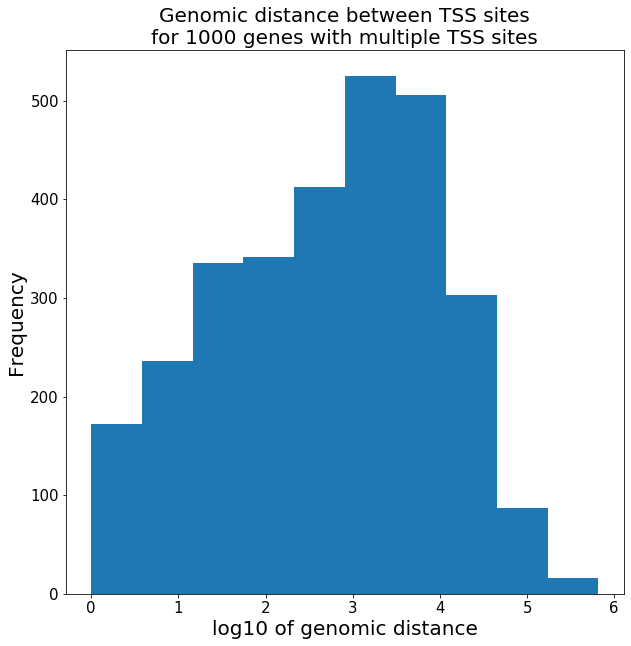

In [20]:
fig = plt.figure(figsize = (10,10))
hist = plt.hist(np.log10(diffs[diffs>0]))
plt.xlabel("log10 of genomic distance", size = 20)
plt.ylabel("Frequency", size = 20)
plt.tick_params(labelsize = 15)
plt.title("Genomic distance between TSS sites\nfor {} genes with multiple TSS sites".format(tot+1), size = 20)

It looks like some TSS sites can be $\textbf{very}$ far away from each other! To simplify things let's just take the top hit for each ensembl ID (Given the way that gene information is downloaded from biomart this will correspond to the transcript {gene_name}_001:

In [21]:
class Gene(F.Feature):
    def __init__(self,
                 fid,
                 chromosome,
                 genebody,
                 strand,
                 promoter,
                 attrs = None,
                 parents = None,
                 children = None):
        super(Gene,self).__init__(fid,
                                  chromosome,
                                  genebody,
                                  attrs = attrs,
                                  parents= parents,
                                  children = children)
        self.attrs['strand'] = strand
        self.attrs['promoter'] = promoter

Now that we've defined our class with some features we might be interested in, let's create a list of gene features which we'll use to link with our TADs:

In [22]:
def make_gene_and_prom_obs(ID):
    '''
    Function to construct a Gene object from our TSS table given some ensembl ID
    '''
    gene = TSS.loc[ID]
    
    #If there is more than one transcript we want to pick the top one!
    if len(gene.values.shape)>1:
        start = gene['Gene Start (bp)'].values[0]
        end = gene['Gene End (bp)'].values[0]
        strand = gene['Strand'].values[0]
        mychrom = gene['Chromosome Name'].values[0]
        name = gene['Associated Gene Name'].values[0]
    else:
        start = gene['Gene Start (bp)']
        end = gene['Gene End (bp)']
        strand = gene['Strand']
        mychrom = gene['Chromosome Name']
        name = gene['Associated Gene Name']

    
    #Create our genebody region
    genebody = [start,end]
    #Making the assumption that the promoter region will be somewhere within 2kb
    #of the TSS (upstream or downstream depends on the strand information)
    if strand == 1:
        myprom = [start - int(2e3), start]
    else:
        myprom = [end, end + int(2e3)]

    #Instantiate a new gene object
    mygene = Gene(ID,
                  mychrom,
                  genebody,
                  strand,
                  promoter = myprom,
                  attrs = {'name': name})
                  
    return mychrom, mygene

'''
Using some multiprocessing here to whizz through all the ensembl IDs
All this is really doing is working in multiple threads to create a
gene object for each gene and store the result in a dictionary 
with chromosomes as keys
'''
chroms = [str(i+1) for i in np.arange(19)]+['X'] 
genes = {chrom: [] for chrom in chroms}
myIDs = list(set(TSS.index.values))

from multiprocessing import Pool
p = Pool()
temp_outputs = p.imap(make_gene_and_prom_obs, (ID for ID in myIDs))
for temp_output in temp_outputs: 
    genes[temp_output[0]].append(temp_output[1])

We can now access gene information by accessing the dictionary of gene objects:

In [23]:
print(genes['1'][10].id)
print("\n")
print(genes['1'][10].attrs['regions'])
print("\n")
print(genes['1'][10].attrs['promoter'])

ENSMUSG00000067750


[21349641, 21352200]


[21347641, 21349641]


## Naive mESC TADs

In [24]:
TADs = pd.read_csv("tutorial_data/TAD_boundaries_mESC.csv",sep = ",")
TADs

,chrom,start,end,Compartment
0,chr1,0,4328000,B
1,chr1,4461000,4761000,A
2,chr1,4782000,5072000,A
3,chr1,5089000,6980000,B
4,chr1,7003000,9437000,B
...,...,...,...,...
2707,chrY,5300000,5426000,B
2708,chrY,5432000,6658000,B
2709,chrY,6665000,6751000,B
2710,chrY,6792000,9788000,B


Let's go ahead and make a TAD class to capture this information:

In [25]:
class TAD(F.Feature_single_condition):
    '''
    Base class to represent a TAD
    '''
    def __init__(self,
                 fid,
                 condition,
                 chromosome,
                 regions,
                 attrs = None,
                 parents = None,
                 children = None):
                         
        super(TAD,self).__init__(fid,
                                 condition,
                                 chromosome,
                                 regions,
                                 attrs = attrs,
                                 parents= parents,
                                 children = children)                    

We can see that we've used:

- A subclass of Feature_single_condition since TADs are condtion specific
- To specify each TAD all we need is a region and a chromosome so we use those as attributes

In [26]:
TAD_dict = {chrom: [] for chrom in chroms}
for idx in TADs.index.values:
    myTAD = TADs.loc[idx]
    mychrom = myTAD['chrom'][3:]
    if mychrom == 'Y':
        continue
    myregion = [myTAD['start'], myTAD['end']]
    
    myID = "TAD_{}".format(idx)
    
    TAD_dict[mychrom].append(TAD(myID,
                                 'naive',
                                 mychrom,
                                 myregion
                                )
                            )

We can now access TAD information as TAD objects:

In [27]:
print(TAD_dict['1'][10].id)
print("\n")
print(TAD_dict['1'][10].attrs['regions'])
print("\n")
print(TAD_dict['1'][10].attrs['chromosome'])

TAD_10


[15026000, 17097000]


1


## Linking TADs and Genes

We only really gain anything from this if we can efficiently link together different sets of features. 'Linking' could be applied very broadly and could be used to add children features of type1 to parent features type2 where feature A of type 1 is a child of feature B of type 2 if:

- their genomic regions overlap
- they have similar binding of a protein
- Feature A is regulated by Feature 2

But how do we go about linking features? The Feature module contains a function link_features described here:

    '''
    Given some list of regions associated with each parent and child, this returns an (N,2) shape
    array detailing the links between parents and children. 
    Arguments:
    parent_regions: A list of (M,2) shape arrays (one per parent) which need not be the same length
                    but which detail the regions associated with each parent.
    child_regions: A list of (M,2) shape arrays (one per child) which need not be the same length
                   but which detail the regions associated with each child.
    
    Returns:
    Links: (N,2) shape array (essentially a COO format sparse matrix) where each row details 
           a link between a parent and a child. 
    '''
    
In this tutorial we'll just look at associating parent features with child features using genomic overlap. Given this, each gene and TAD will have to be associated with a set of regions. We provide the function with a list of these regions for the parent sets and child sets and the function tells us which members of the parent and child sets overlap.

### TAD overlap with gene bodies

#### Chromosome 1

In [28]:
gene_regions = [np.array(item.attrs['regions']).reshape(1,2).astype('int32') for item in genes['1']]
TAD_regions = [np.array(item.attrs['regions']).reshape(1,2).astype('int32') for item in TAD_dict['1']]

We've therefore associated each gene and TAD with a region encoded as a shape (1,2) integer array. If we now call link_features then this will return an array where each row details a TAD (parent) - gene (child) pair: 

In [29]:
links = F.link_features(TAD_regions,
                        gene_regions)
print(links)

[[   0  210]
 [   0  529]
 [   0  783]
 ...
 [ 195 1650]
 [ 195 1713]
 [ 195 1918]]


Note that this is fairly quick as long as each parent and child is associated with a single region. However, it is possible to associate a Feature with multiple regions - link features will still work in this case, it will just be slower! Anyway, let's go ahead and add the gene children to the parent TADs:

In [30]:
for link in links:
    TAD_dict['1'][link[0]].add_child(genes['1'][link[1]], 'genebody')
    genes['1'][link[1]].add_parent(TAD_dict['1'][link[0]], 'genebody_TAD')

Now we can identify for each TAD, the genes which are overlapped with that TAD:

In [31]:
print([item.id for item in TAD_dict['1'][10].children['genebody']])

['ENSMUSG00000042686', 'ENSMUSG00000073737', 'ENSMUSG00000089982', 'ENSMUSG00000091020', 'ENSMUSG00000067795', 'ENSMUSG00000088943', 'ENSMUSG00000025920', 'ENSMUSG00000077377', 'ENSMUSG00000032719', 'ENSMUSG00000025921', 'ENSMUSG00000090498', 'ENSMUSG00000097744', 'ENSMUSG00000079658', 'ENSMUSG00000088829', 'ENSMUSG00000025779', 'ENSMUSG00000025940', 'ENSMUSG00000092083', 'ENSMUSG00000025939', 'ENSMUSG00000025925', 'ENSMUSG00000043716']


Note that above, when we have called add_child and add_parent we have specified that these parent-child links are associated wiht the genebody. We can do a similar analysis for gene promoter regions:

In [32]:
gene_regions = [np.array(item.attrs['promoter']).reshape(1,2).astype('int32') for item in genes['1']]
TAD_regions = [np.array(item.attrs['regions']).reshape(1,2).astype('int32') for item in TAD_dict['1']]

links = F.link_features(TAD_regions,
                        gene_regions)

for link in links:
    TAD_dict['1'][link[0]].add_child(genes['1'][link[1]], 'promoter')
    genes['1'][link[1]].add_parent(TAD_dict['1'][link[0]], 'promoter_TAD')

This is very useful! Let's now take a look at the distribution of the number of promoters in each TAD, scaled by the length of that TAD:

Text(0.5, 1.0, 'Promoter density per TAD')

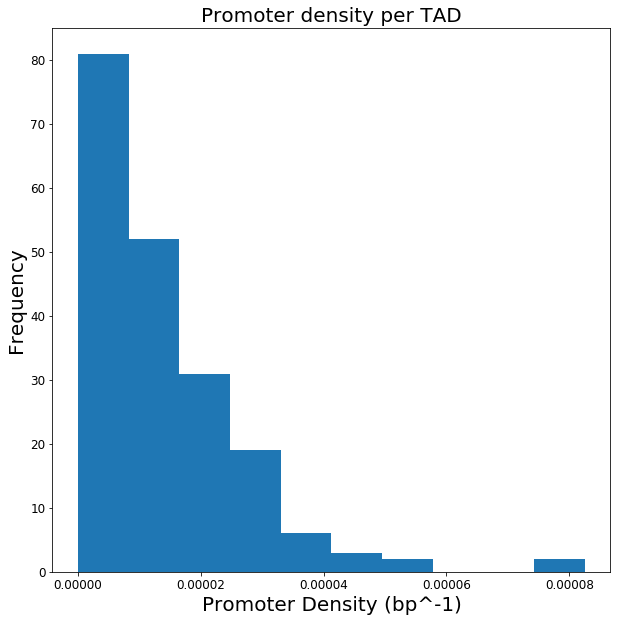

In [33]:
promdensity_chr1 = [len(item.children['promoter'])/(item.attrs['regions'][1] - item.attrs['regions'][0]) if 'promoter' in item.children else 0 for item in TAD_dict['1']]

fig = plt.figure(figsize = (10,10))
hist = plt.hist(promdensity_chr1)
plt.xlabel("Promoter Density (bp^-1)", size = 20)
plt.ylabel("Frequency", size = 20)
plt.tick_params(labelsize = 12)
plt.title("Promoter density per TAD".format(tot+1), size = 20)

## Combining with the Datatrack module
This is all very nice but really what we want is simple ways to manipulate features alongside Datatracks! Let's do that here. Suppose we wanted to know whether Nanog binding to promoters shows significant correlation for genes within the same TAD. Let's go ahead and investigate this now.

First things first, we need to load our Nanog datatrack:

In [34]:
nanog_file = "tutorial_data/GSEXXXXXHendrich20161026_Nanog_ESC_peaks.npz"
nanog = Dt.DataTrack_rvp("Nanog").from_npz(nanog_file)

Let's now link TADs and promoters for all genes:

In [35]:
#Clear out our previous children and parents
for chrom in chroms:
    for TAD in TAD_dict[chrom]:
        if 'promoter' in TAD.children:
            del(TAD.children['promoter'])
    for gene in genes[chrom]:
        if 'promoter_TAD' in gene.parents:
            del(gene.parents['promoter_TAD'])
    
for chrom in chroms:
    prom_regions = [np.array(item.attrs['promoter']).reshape(1,2).astype('int32') for item in genes[chrom]]
    TAD_regions = [np.array(item.attrs['regions']).reshape(1,2).astype('int32') for item in TAD_dict[chrom]]

    links = F.link_features(TAD_regions,
                            prom_regions)

    for link in links:
        TAD_dict[chrom][link[0]].add_child(genes[chrom][link[1]], 'promoter')
        genes[chrom][link[1]].add_parent(TAD_dict[chrom][link[0]], 'promoter_TAD')

Now let's assign some Nanog attributes to our promoters:

In [36]:
for chrom in chroms:
    gene_regions = [np.array(item.attrs['promoter']).reshape(1,2).astype('int32') for item in genes[chrom]]
    max_nanog = nanog.stats(chrom, gene_regions, stats_type = 'max')
    nanog_coverage = nanog.stats(chrom,gene_regions, stats_type = 'coverage')
    
    for idx in np.arange(len(max_nanog)):
        genes[chrom][idx].attrs['promoter_maximum_nanog_signal'] = max_nanog[idx]
        genes[chrom][idx].attrs['promoter_nanog_coverage'] = nanog_coverage[idx]

Now let's look at the distributions of within-promoter maximum Nanog signal (WP-MNS) in each TAD. In particular lets look at the mean WP-MNS versus the standard deivation in WP-MNS. If binding of Nanog to one promoter in a TAD raised the probability of Nanog binding to another promoter in the TAD we would expect the standard deviation in Nanog binding to stay relatively constant when compared with the mean. Let's see if this is what we see:

### Maximum nanog promoter signal for genes in same TAD

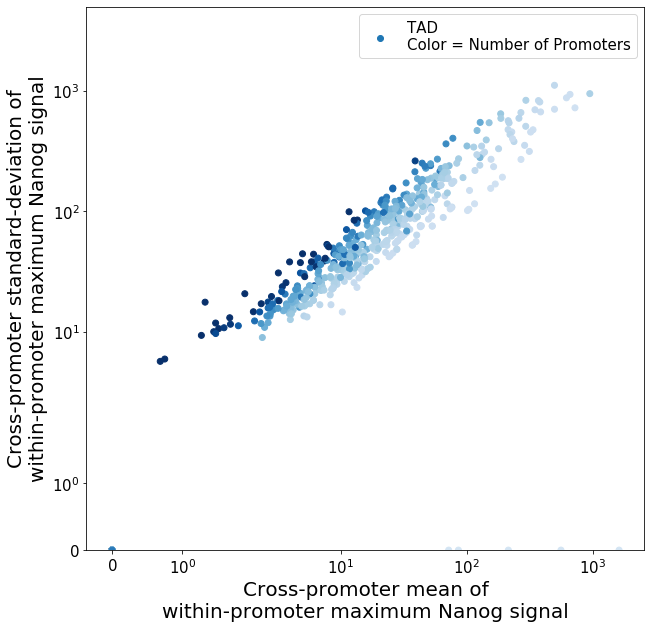

In [37]:
means = []
std = []
nums = []
for chrom in chroms:
    for TAD in TAD_dict[chrom]:
        if 'promoter' in TAD.children:
            proms = TAD.children['promoter']
            nums.append(len(proms))
            means.append(np.mean([item.attrs['promoter_maximum_nanog_signal'] for item in proms]))
            std.append(np.std([[item.attrs['promoter_maximum_nanog_signal']] for item in proms]))

fig = plt.figure(figsize = (10,10))
plt.scatter(means, std, c = nums, cmap = plt.cm.Blues, vmin = -10, vmax = 50, label = "TAD\nColor = Number of Promoters")
plt.xscale('symlog')
plt.yscale('symlog')
plt.ylim([0,5e3])
plt.tick_params(labelsize = 15)
plt.xlabel("Cross-promoter mean of\nwithin-promoter maximum Nanog signal", size = 20)
plt.ylabel("Cross-promoter standard-deviation of\nwithin-promoter maximum Nanog signal", size = 20)
plt.legend(prop = {'size':15})

It looks as if we have a noisy linear relationship between the mean and the variance of within-promoter maximum Nanog signal (WP-MN).

It also seems like for a higher mean WP-MN is associated with lower numbers of promoters. This could just be down to the specificity of Nanog binding - if Nanog only binds 5% of promoters then for a TAD with lots of promoters, the within-TAD mean WP-MN will be dragged down my most promoters having no Nanog binding. Therefore we don't see this trend in the within-TAD standard deivation of WP-MN.

It looks as if Nanog doesn't show huge amount of TAD specificity! Let's double check this by looking at a histogram of mean WP-MNS within each TAD:

Text(0, 0.5, 'Frequency')

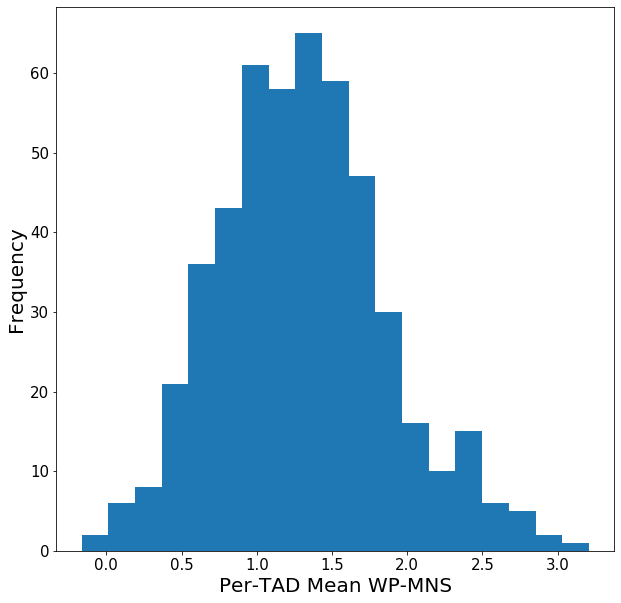

In [38]:
fig = plt.figure(figsize = (10,10))
x = np.array(means)
hist = plt.hist(np.log10(x[x>0]), bins = 'auto')
plt.tick_params(labelsize = 15)
plt.xlabel("Per-TAD Mean WP-MNS", size = 20)
plt.ylabel("Frequency", size = 20)